In [1]:
import os
import sys
import random
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, applications, preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- GPU Verification and Setup ---

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    try:
        # Set memory growth to True for all GPUs to prevent TensorFlow from allocating all memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth has been set.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("Warning: No GPU detected. Model will train on CPU.")

TensorFlow Version: 2.10.0
Keras Version: 2.10.0
Num GPUs Available: 1
GPU memory growth has been set.


In [2]:
# Cell 2 — Dataset Exploration & Visualization (with corruption check)

from PIL import UnidentifiedImageError

DATA_DIR = Path("datasets")  # make sure dataset is unzipped into this folder
image_ext = {".jpg", ".jpeg", ".png", ".bmp"}

# Collect dataset info
class_counts = {}
sample_images = {}
corrupt_images = []

for class_dir in sorted(DATA_DIR.iterdir()):
    if class_dir.is_dir():
        imgs = [p for p in class_dir.iterdir() if p.suffix.lower() in image_ext]
        class_counts[class_dir.name] = len(imgs)

        # Check corruption
        for p in imgs:
            try:
                with Image.open(p) as im:
                    im.verify()  # Raises error if image is corrupt
            except (UnidentifiedImageError, Exception) as e:
                corrupt_images.append((p, str(e)))

        # Collect some random samples
        if imgs:
            sample_images[class_dir.name] = random.sample(imgs, min(3, len(imgs)))

# --- Summary of dataset ---
print("📊 Dataset Summary")
print("-------------------------")
print("Number of classes:", len(class_counts))
for cls, count in class_counts.items():
    print(f"{cls:<25} -> {count} images")


📊 Dataset Summary
-------------------------
Number of classes: 29
Apple__Healthy            -> 2438 images
Apple__Rotten             -> 2925 images
bad_images                -> 0 images
Banana__Healthy           -> 1999 images
Banana__Rotten            -> 2797 images
Bellpepper__Healthy       -> 611 images
Bellpepper__Rotten        -> 591 images
Carrot__Healthy           -> 619 images
Carrot__Rotten            -> 579 images
Cucumber__Healthy         -> 608 images
Cucumber__Rotten          -> 593 images
Grape__Healthy            -> 200 images
Grape__Rotten             -> 200 images
Guava__Healthy            -> 200 images
Guava__Rotten             -> 200 images
Jujube__Healthy           -> 200 images
Jujube__Rotten            -> 200 images
Mango__Healthy            -> 1813 images
Mango__Rotten             -> 2247 images
Orange__Healthy           -> 2075 images
Orange__Rotten            -> 2186 images
Pomegranate__Healthy      -> 200 images
Pomegranate__Rotten       -> 200 images
Potato__

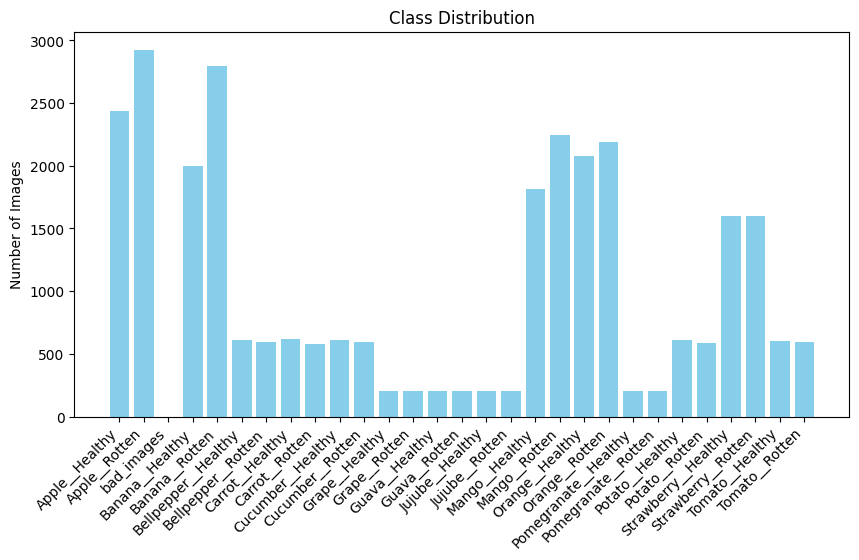

In [3]:
# --- Class distribution chart ---
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

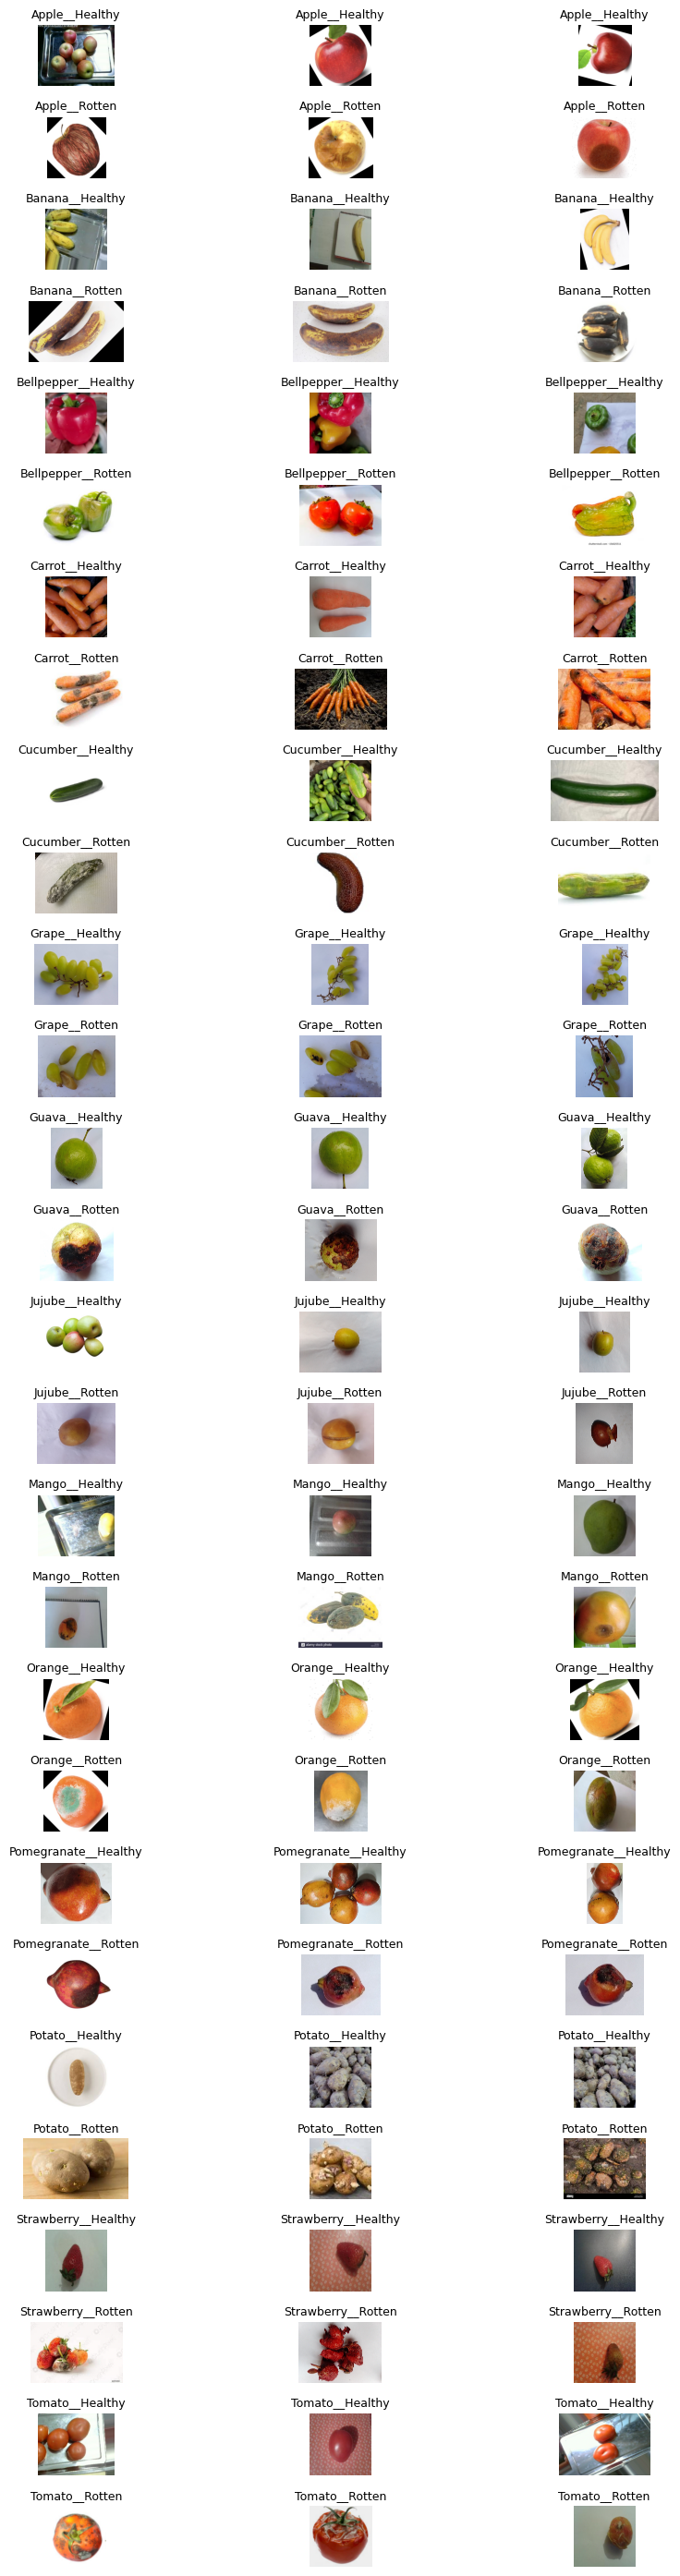

In [4]:
# --- Sample images per class ---
fig, axs = plt.subplots(len(sample_images), 3, figsize=(10, len(sample_images)))
if len(sample_images) == 1:
    axs = [axs]
for i, (cls, img_paths) in enumerate(sample_images.items()):
    for j, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        axs[i][j].imshow(img)
        axs[i][j].set_title(cls, fontsize=9)
        axs[i][j].axis("off")
plt.tight_layout()
plt.show()

In [5]:
# --- Corrupt image report ---
if corrupt_images:
    print(f"⚠️ Found {len(corrupt_images)} corrupt/unreadable images.")
    print("Examples:")
    for bad_img, err in corrupt_images[:5]:
        print("-", bad_img, "->", err)
else:
    print("✅ No corrupt images found.")

✅ No corrupt images found.


In [6]:
# Cell 3 — Move corrupt images to a separate folder

import shutil

BAD_DIR = DATA_DIR / "bad_images"
BAD_DIR.mkdir(exist_ok=True)

moved_count = 0
for bad_img, _ in corrupt_images:
    dest = BAD_DIR / bad_img.name
    try:
        shutil.move(str(bad_img), dest)
        moved_count += 1
    except Exception as e:
        print(f"Failed to move {bad_img}: {e}")

print(f"✅ Moved {moved_count} corrupt images to {BAD_DIR}")


✅ Moved 0 corrupt images to datasets\bad_images


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Define Image and Batch Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- Create Separate Data Generators for Training and Validation ---

# 1. Training Data Generator: WITH data augmentation
# Data augmentation is a key technique to prevent overfitting on the training set.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # We'll use this split to separate the files
)

# 2. Validation/Test Data Generator: WITHOUT data augmentation
# We only need to rescale the validation data. We don't augment it because we
# want to evaluate the model's performance on the original, unmodified images.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# --- Flow Data from Directory ---

# Training Generator
# Uses the 'training' subset of the data with augmentations applied.
print("Flowing training data:")
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training",
    shuffle=True,
    seed=42
)

# Validation Generator
# Uses the 'validation' subset of the data with NO augmentations.
print("\nFlowing validation data:")
val_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation",
    shuffle=False,  # No need to shuffle validation data
    seed=42
)

# --- Print Class Mapping ---
print("\nClass indices found:", train_generator.class_indices)

Flowing training data:
Found 23431 images belonging to 29 classes.

Flowing validation data:
Found 5846 images belonging to 29 classes.

Class indices found: {'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27, 'bad_images': 28}


In [8]:
# Cell 5 — Build VGG16 Transfer Learning Model (auto-detect classes)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Detect number of classes from the train generator
num_classes = train_generator.num_classes
print(f"Detected {num_classes} classes.")

# Load VGG16 base model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Build sequential model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # dynamic number of classes
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # for integer labels
    metrics=['accuracy']
)

# Summary
model.summary()

Detected 29 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 29)                727581    
                                                                 
Total params: 15,442,269
Trainable params: 727,581
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- 1. Create a Directory to Save the Model ---
# Ensure the 'models' directory exists before we start training.
os.makedirs('models', exist_ok=True)

# --- 2. Define Callbacks for Smart Training ---

# ModelCheckpoint: Saves the best version of the model during training.
# - monitor='val_loss': It watches the validation loss.
# - save_best_only=True: It only saves the model when the validation loss improves.
checkpoint = ModelCheckpoint(
    filepath='models/healthy_vs_rotten.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# EarlyStopping: Stops training if the model is no longer improving.
# - monitor='val_loss': It watches the validation loss.
# - patience=3: It will wait for 3 full epochs without improvement before stopping.
# - restore_best_weights=True: When training stops, it restores the model weights from the best epoch.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# --- 3. Set Training Parameters ---
EPOCHS = 10

# --- 4. Train the Model ---
# This is where the GPU does all the work. Keras automatically handles it.
# The 'history' object will store the training and validation loss/accuracy for each epoch.
print("\n" + "="*50)
print(f"🚀 Starting model training for {EPOCHS} epochs...")
print("="*50)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)

print("\n✅ Training finished!")


🚀 Starting model training for 10 epochs...
Epoch 1/10
140/733 [====>.........................] - ETA: 2:58 - loss: 2.6628 - accuracy: 0.2319

c:\Users\swaro\anaconda3\envs\smart_sorting\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 [==============================] - ETA: 0s - loss: 1.7846 - accuracy: 0.4617
Epoch 1: val_loss improved from inf to 1.02428, saving model to models\healthy_vs_rotten.h5
733/733 [==============================] - 272s 367ms/step - loss: 1.7846 - accuracy: 0.4617 - val_loss: 1.0243 - val_accuracy: 0.7190
Epoch 2/10
733/733 [==============================] - ETA: 0s - loss: 1.0748 - accuracy: 0.6769
Epoch 2: val_loss improved from 1.02428 to 0.78510, saving model to models\healthy_vs_rotten.h5
733/733 [==============================] - 414s 565ms/step - loss: 1.0748 - accuracy: 0.6769 - val_loss: 0.7851 - val_accuracy: 0.7747
Epoch 3/10
733/733 [==============================] - ETA: 0s - loss: 0.8824 - accuracy: 0.7362
Epoch 3: val_loss improved from 0.78510 to 0.67138, saving model to models\healthy_vs_rotten.h5
733/733 [==============================] - 383s 522ms/step - loss: 0.8824 - accuracy: 0.7362 - val_loss: 0.6714 - val_accuracy: 0.8122
Epoch 4/10
733/733 [==============

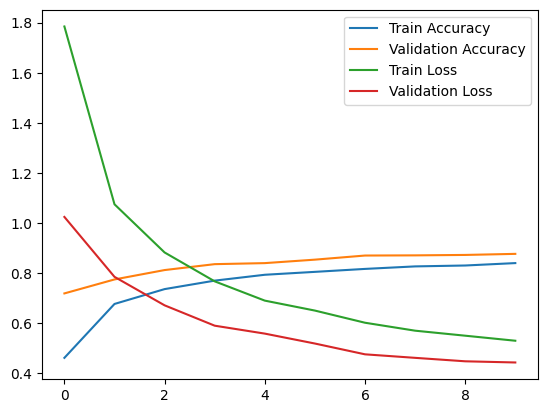

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [15]:
# --- Cell 7: Model Evaluation and Predictions (Fixed) ---

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Evaluate model
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"\nValidation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

175/183 [===========================>..] - ETA: 2s - loss: 0.4175 - accuracy: 0.8857

c:\Users\swaro\anaconda3\envs\smart_sorting\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


183/183 [==============================] - 64s 343ms/step - loss: 0.4433 - accuracy: 0.8768

Validation Accuracy: 0.8768, Validation Loss: 0.4433


In [16]:
# Predictions
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)

183/183 [==============================] - 87s 473ms/step


In [17]:
# True labels
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

In [18]:
# Filter class labels to match actual classes
unique_classes = np.unique(y_true)
filtered_labels = [class_labels[i] for i in unique_classes]

In [19]:

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=unique_classes, target_names=filtered_labels))


Classification Report:
                      precision    recall  f1-score   support

      Apple__Healthy       0.91      0.53      0.67       487
       Apple__Rotten       0.84      0.95      0.89       585
     Banana__Healthy       0.99      0.90      0.94       399
      Banana__Rotten       0.95      0.98      0.96       559
 Bellpepper__Healthy       0.80      0.82      0.81       122
  Bellpepper__Rotten       0.73      0.63      0.67       118
     Carrot__Healthy       0.93      0.96      0.94       123
      Carrot__Rotten       0.87      0.90      0.88       115
   Cucumber__Healthy       0.90      0.97      0.93       121
    Cucumber__Rotten       0.97      0.94      0.95       118
      Grape__Healthy       0.77      0.90      0.83        40
       Grape__Rotten       0.89      0.80      0.84        40
      Guava__Healthy       0.58      0.95      0.72        40
       Guava__Rotten       0.64      0.80      0.71        40
     Jujube__Healthy       0.47      0.85    

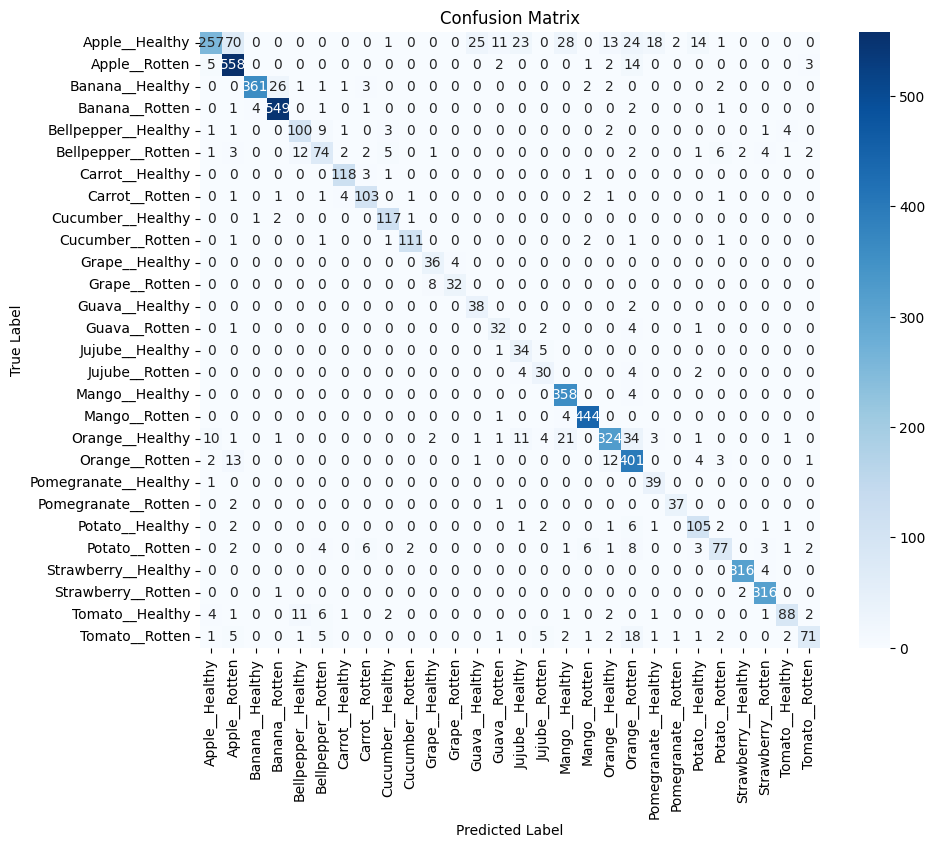

In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_labels, yticklabels=filtered_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

FileUpload(value=(), accept='image/*', description='Upload')

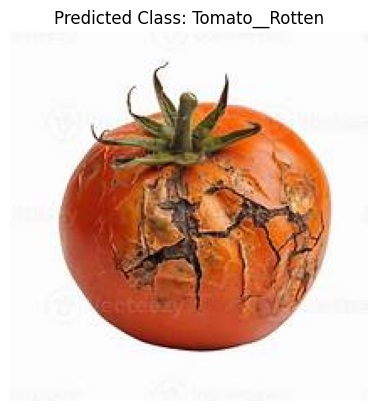

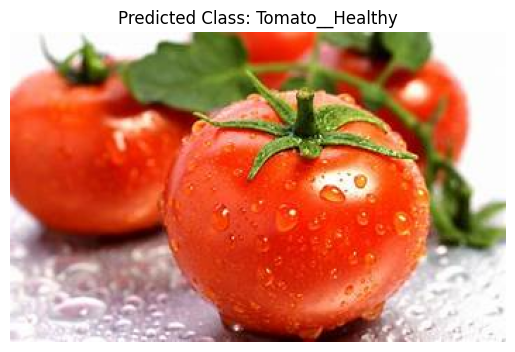

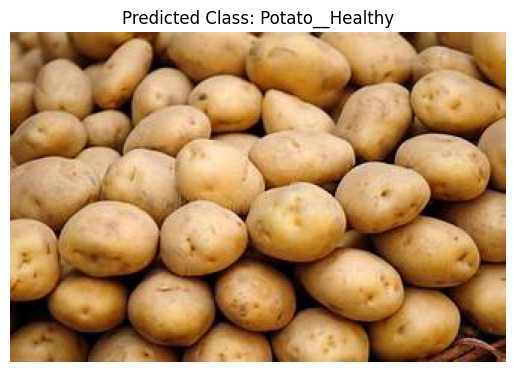

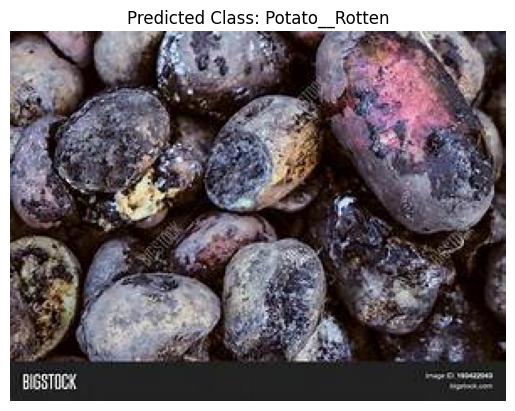

In [22]:
# --- Cell 8: Upload and Test Single Image (Updated for ipywidgets latest) ---

from IPython.display import display
import ipywidgets as widgets
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# 1. Create a file upload widget
upload = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=False     # Single file only
)

display(upload)

def predict_uploaded_image(change):
    if len(upload.value) == 0:
        return
    
    # --- Updated for ipywidgets >=8.0 ---
    uploaded_file = upload.value[0]  # get first (and only) file
    content = uploaded_file['content'] if isinstance(uploaded_file, dict) else uploaded_file.data
    
    # Open image
    img = Image.open(BytesIO(content)).convert('RGB')
    img_resized = img.resize((224,224))  # VGG16 input size
    
    # Convert to array
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Predict
    pred_probs = model.predict(img_array)
    pred_class_idx = np.argmax(pred_probs)
    pred_class_name = list(train_generator.class_indices.keys())[pred_class_idx]
    
    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {pred_class_name}")
    plt.show()
    
    print(f"\nPredicted Class: {pred_class_name}")
    print(f"Prediction Probabilities: {pred_probs}")

# 2. Trigger prediction when a file is uploaded
upload.observe(predict_uploaded_image, names='value')